Data: We are provided with daily sales data for each store-item combination, but our task is to predict sales at a monthly level.
<br>
You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

### Taken from notebook "Times Series Basics: Exploring Traditional TS"


https://www.kaggle.com/code/jagangupta/time-series-basics-exploring-traditional-ts

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv('sales_train.csv')
df_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [3]:
df_train.sort_values('date')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
16164,01.01.2013,0,28,11613,1499.0,1.0
101474,01.01.2013,0,51,10283,667.0,1.0
10197,01.01.2013,0,19,2828,499.0,1.0
101457,01.01.2013,0,51,10390,150.0,1.0
101455,01.01.2013,0,51,10591,110.0,1.0
...,...,...,...,...,...,...
2263531,31.12.2014,23,10,15784,195.0,1.0
2238358,31.12.2014,23,31,18624,499.0,1.0
2238360,31.12.2014,23,31,18622,169.0,1.0
2210313,31.12.2014,23,59,9412,299.0,1.0


In [4]:
### predict sales on a monthly basis
df_train['month'] = df_train.date

df_train.month = pd.DatetimeIndex(df_train['month']).month

In [5]:
df_train.sort_values(by='month')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month
2328615,18.01.2015,24,18,5039,2599.0,1.0,1
533284,01.06.2013,5,29,19602,99.0,1.0,1
212988,01.02.2013,1,25,15452,548.7,1.0,1
533278,01.06.2013,5,29,19600,399.0,1.0,1
212993,01.02.2013,1,25,15458,449.0,1.0,1
...,...,...,...,...,...,...,...
2237620,28.12.2014,23,31,20614,1099.0,1.0,12
2237621,27.12.2014,23,31,20614,1099.0,3.0,12
2237622,26.12.2014,23,31,20614,1099.0,1.0,12
2237614,13.12.2014,23,31,20606,849.0,3.0,12


<AxesSubplot:>

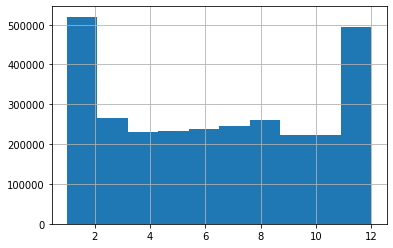

In [6]:
df_train['month'].hist()

we can see seasonality in the sales, with a peek of sales in December and January (Christmas). 

In [7]:
### import time series libraries

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.tsa.api as sm
import scipy.stats as scs


In [8]:
### aggregate the date month, shop id and item id, by date, item price and item count per day

monthly_sales = df_train.groupby(['date_block_num', 'shop_id', 'item_id'])[
    'date', 'item_price', 'item_cnt_day'].agg({'date' : ['min', 'max'], 
                                               'item_price' : 'mean',
                                              'item_cnt_day' : 'sum'})

In [9]:
monthly_sales

date             item_price item_cnt_day
                                       min         max       mean          sum
date_block_num shop_id item_id                                                
0              0       32       03.01.2013  31.01.2013      221.0          6.0
                       33       03.01.2013  28.01.2013      347.0          3.0
                       35       31.01.2013  31.01.2013      247.0          1.0
                       43       31.01.2013  31.01.2013      221.0          1.0
                       51       13.01.2013  31.01.2013      128.5          2.0
...                                    ...         ...        ...          ...
33             59      22087    05.10.2015  23.10.2015      119.0          6.0
                       22088    03.10.2015  27.10.2015      119.0          2.0
                       22091    03.10.2015  03.10.2015      179.0          1.0
                       22100    18.10.2015  18.10.2015      629.0          1.0
                       22102    16.10.2015  16.10.2015     1250.0          1.0

[1609124 rows x 4 columns]

File descriptions

sales_train.csv - the training set. Daily historical data from January 2013 to October 2015. 

test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.

sample_submission.csv - a sample submission file in the correct format.

items.csv - supplemental information about the items/products.

item_categories.csv  - supplemental information about the items categories.

shops.csv- supplemental information about the shops.


Data fields

ID - an Id that represents a (Shop, Item) tuple within the test set
shop_id - unique identifier of a shop
item_id - unique identifier of a product
item_category_id - unique identifier of item category
item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
item_price - current price of an item
date - date in format dd/mm/yyyy
date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
item_name - name of item
shop_name - name of shop
item_category_name - name of item category

In [10]:
items = pd.read_csv('items.csv')
sub = pd.read_csv('sample_submission.csv')
item_cat = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

test = pd.read_csv('test.csv')

In [11]:
sales = df_train

In [12]:
#forfun = sales.groupby(['month', 'shop_id', 'item_id'])['date_block_num', 'date', 'item_price'].agg({
#    'date_block_num' : ['min', 'max'],
#    'date' : ['min', 'max'],
#    'item_price': 'average'})

In [13]:
### how to create the block date month variable

In [14]:
## we have different items and want to compute the number of sales 
## in the test month. But what type of sales? we sell products from
## different categories. So first, we take a look at the behavior
## of each category. 

x = items.groupby('item_category_id').count()
x = x.sort_values('item_id', ascending=False)
x

,item_name,item_id
item_category_id,,
40,5035,5035
55,2365,2365
37,1780,1780
31,1125,1125
58,790,790
...,...,...
1,2,2
50,2,2
10,1,1


In [15]:
x = x.iloc[0:10].reset_index()
x

,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790
5,30,756,756
6,72,666,666
7,19,628,628
8,61,598,598
9,23,501,501


/Users/ruilapuskas/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Item Count Per Category')

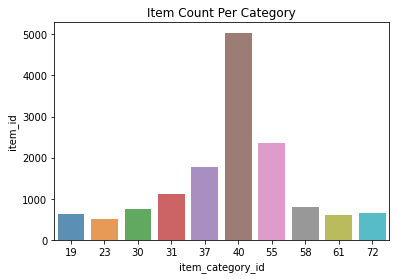

In [16]:
plt.figure()
ax = sns.barplot(x.item_category_id, x.item_id, alpha = 0.8)

plt.title('Item Count Per Category')

In [17]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [18]:
y = shops.groupby('shop_id').count()
y.head()

,shop_name
shop_id,
0,1
1,1
2,1
3,1
4,1


We can see a trend in the type of items that are the most sold. We can have different levels of granularity here, predict the number of sales for a particular item category, or for a particular store. 

let us first look at the total sales for the whole company. 

In [19]:
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month
0,02.01.2013,0,59,22154,999.00,1.0,2
1,03.01.2013,0,25,2552,899.00,1.0,3
2,05.01.2013,0,25,2552,899.00,-1.0,5
3,06.01.2013,0,25,2554,1709.05,1.0,6
4,15.01.2013,0,25,2555,1099.00,1.0,1
...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,10
2935845,09.10.2015,33,25,7460,299.00,1.0,9
2935846,14.10.2015,33,25,7459,349.00,1.0,10
2935847,22.10.2015,33,25,7440,299.00,1.0,10


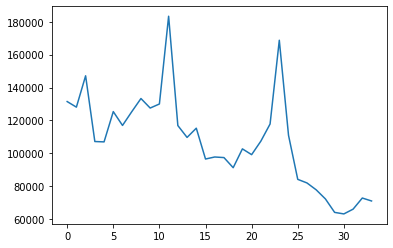

In [20]:
### float variable = dataframe.groupby(X axis)[Y AXIS].sum()

ts = sales.groupby('date_block_num')['item_cnt_day'].sum()
ts.astype('float')
plt.plot(ts)

this time series is not stationary. it has a trend and seasonality. 

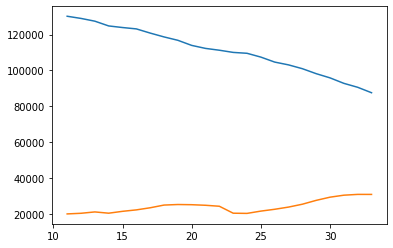

In [21]:
plt.figure()
plt.plot(ts.rolling(window = 12, center = False).mean(), label='Rolling Mean')
plt.plot(ts.rolling(window = 12, center = False).std(), label='Rolling std')


## the window value is the period of the time series

the rolling window enables us to see the seasonality in the mean and the trend in the increasing variance. We further check that with a decomposition into trend, seasonality and residuals. 

In [22]:
#!pip3 install statsmodels --upgrade

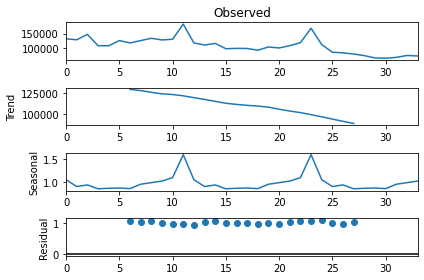

In [26]:
import statsmodels.api as sm

# TIME SERIES IS A MULTIPLICATIVE FUNCTION OF TREND, SEASONALITY AND RESIDUALS
### TS = T * R * S
res = sm.tsa.seasonal_decompose(ts.values, period=12,model='multiplicative')

fig = res.plot()

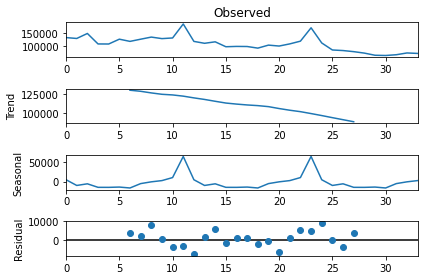

In [27]:
# TIME SERIES IS AN ADDITIVE FUNCTION OF TREND, SEASONALITY AND RESIDUAL
#### TS = T + S + R
res = sm.tsa.seasonal_decompose(ts.values, period=12,model='additive')

fig = res.plot()

the scales change for the last two plots, seasonal and residual. 



When looking at the behaviors in both models, we can see that the trend (mean) decreases with time, and we can see seasonality. 

Homoscedasticity = variance of the TS is not a function of time. 


To check for stationarity in a time series, we can use the Dickey Fuller test. ADF. 
other tests include the KPSS and the Phillips-Perron test. 

In [28]:
## adf is the augmented dickey fuller test 
## ADF is done on a 1D array, so here it will be x the array defined above
### difference between AIC and BIC
### BIC is more parsimonous when it penalizes model complexity. 
def test_stationarity(ts):
    dftest = adfuller(ts, autolag='BIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Nb of lags used', 'Nb of observations used'])

    for key, value in dftest[4].items() :
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


In [29]:
test_stationarity(ts)

Test Statistic             -2.395704
p-value                     0.142953
Nb of lags used             0.000000
Nb of observations used    33.000000
Critical Value (1%)        -3.646135
Critical Value (5%)        -2.954127
Critical Value (10%)       -2.615968
dtype: float64


If the p-value of the test is greater than 0.05, we fail to reject the null hypothesis and the time series is non stationary. 

we remove the trend from the time series. 

In [30]:
from pandas import Series

## create a differenced series
def difference(dataset, interval=1) :
    diff= list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

def inverse_difference(last_ob, value):
    return value + last_ob


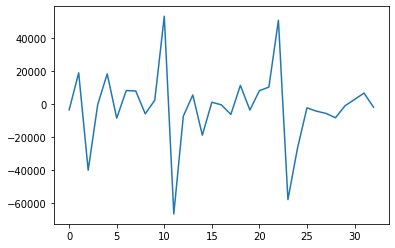

In [31]:
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
ts.astype('float')
plt.figure()
plt.plot(difference(ts))

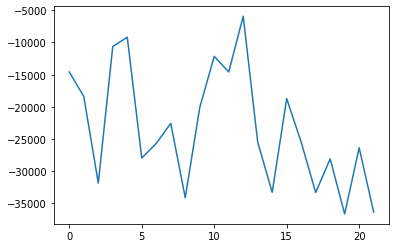

In [32]:
plt.figure()
plt.plot(difference(ts,12))

In [33]:
new_ts = difference(ts, 12)

In [34]:
test_stationarity(new_ts)

Test Statistic             -3.270101
p-value                     0.016269
Nb of lags used             0.000000
Nb of observations used    21.000000
Critical Value (1%)        -3.788386
Critical Value (5%)        -3.013098
Critical Value (10%)       -2.646397
dtype: float64


p-value < 0.05 so the time series is now stationary. 

**Understand AIC and BIC ---> be able to explain.**

AR = autoregressive model
MA = moving average model. 

MA: the next value in the series is a function of the average of the previous n number of values. 

AR: the errors of the next value is a function of the errors in the previous n number of values. 

ARMA is a combination of both. 

How to find out if our time series is an MA or AR process?

In [41]:
def tsplot(y, lags=None, figsize=(10,8), style='bmh', title=''):
    if not isinstance(y, pd.Series) :
        y = pd.Series(y)
    
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax = pacf_ax, alpha=0.5)
        sm.qqplot(y, line = 's', ax=qq_ax)
        
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        
        plt.tight_layout()
    return

In [42]:
#!pip3 install matplotlib --upgrade

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

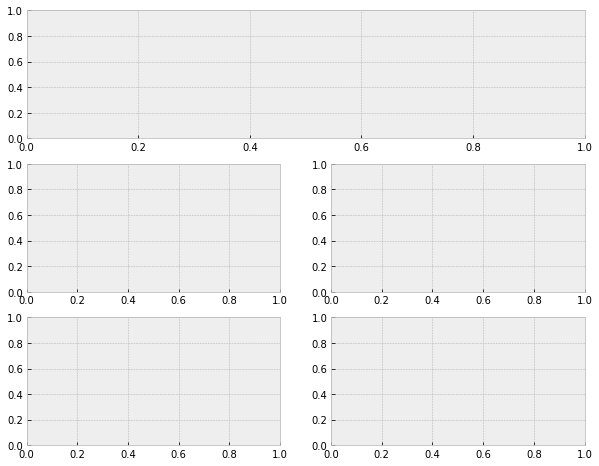

In [43]:
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]

limit=12
_ = tsplot(x, lags=limit, title='AR(1) Process Example')

An AR(1) process has a partial autocorrelation function going to zero at lag 1. 





Rappel: an autoregressive model of order p is defined by <br>

$X_t = \sum_{j=1}^p \phi_j X_{t-j} + \omega_t$

<br> where $\omega_t$ is a white Noise N(0, $\sigma^2$) 

the phis are the model coefficients. 


Interpretation/ a realization at time t is a linear combination of the p previous realizations plus some noise term. So knowing the n previous realizations is enough to know the n+1 st one. Regression comes from the notion of returning to the mean, to the previous status. This is **not** a linear trend model (which assume that the realization increases or decreases through time). 

<br>
If p = 0, there is no autoregression term because Xt = wt. 

<br>
In the case of p = 1 and phi_1 = 1, we have Xt = X(t-1) + wt and that is called a **random walk model**. This model obviously does not capture outlying cases, since it only looks at the day previous: what if one day had particularly high/low value? By predicting that the same value will be repeated in the next time period, the random walk model overreacts to extreme cases. 

<br> 
Hence the importance of the notion of regression towards the mean. 


<br> 
The phis of the AR model can be found using the polynomial characteristic: 
$BXt = Xt-1 <=> \Phi(B) = 1 - \sum_{j=1}^p \phi_j B^j$.  
$\Phi(B)X_t = \omega_t$

B is also called the lag operator. It is basically the coefficient that we have to multiply Xt with to fall back to Xt-1. 
<br>

/!\ The lag is different from the window/the period of the time series. The lag operator has no units, the window is homogenous to a time. /!\

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

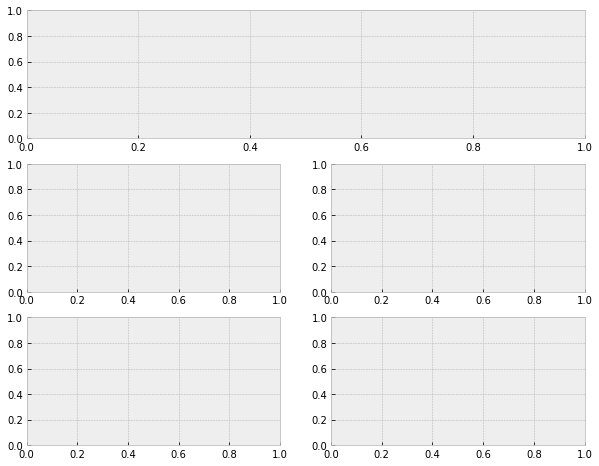

In [37]:
## AR 2 process
n = int(1000)
alphas = np.array([0.444, 0.333])
betas = np.array([0.]) 

ar = np.r_[1, - alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar = ar, ma = ma, nsample = n)
_ = tsplot(ar2, lags=12, title='AR(2) Process Example')

We can see the PACF cutting out at lag = 2. <br>

**In practice, it is rare to use an autoregressive model of more than 2 orders.**

Now let's look at a moving average model. 

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

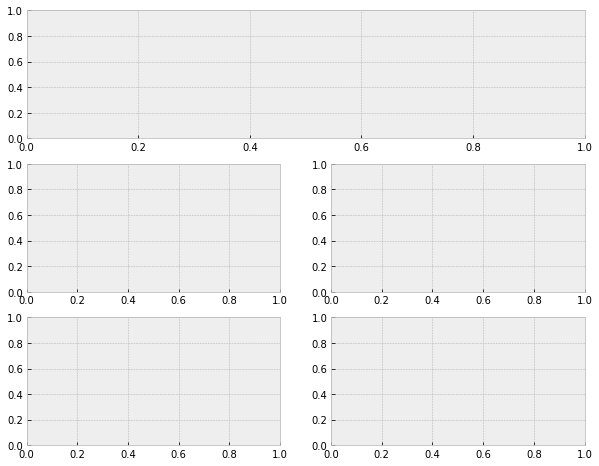

In [44]:
n = int(1000)

alphas = np.array([0.])
betas = np.array([0.8])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
limit=12
_ = tsplot(ma1, lags=limit, title='MA(1) process')

We can see that this time, it's the ACF that cuts off at lag=1. 

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

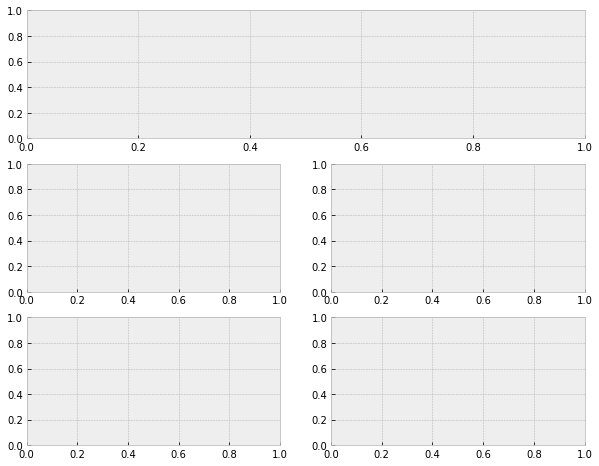

In [45]:
n = int(1000)

alphas = np.array([0.])
betas = np.array([0.6, 0.4])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
limit=12
_ = tsplot(ma1, lags=limit, title='MA(2) process')

For MA 2, ACF cuts off at 2. 

For the moving average model, the equation is:

$X_t = \omega_t + \sum_{j=1}^q \theta_j \omega_{t-j}$

<br> where the omegas are still white noise error terms. 

The idea is in the randomness. In a way, the randomness (omega) affects the current time period, and q periods in the future. whereas in the AR model, since we have Xt = ... + omega(t), the randomness affects the next time period t+1, and the next and so on. 

**the randomness from the q previous time periods is propagated to the future values Xt, whereas in an AR model, the randomness only appear for the current time period Xt.**


Interpretation: $\hat X_t = mean + phi_1*\omega_{t-1}$ and let's say phi_1 = 0.5. <br>
Mean: if nothing changes, every time period, we have Xt = mean. Introducing the randomness in omega(t). 
**I'm always bringing mean, but I'm going to adjust by 50% of whatever my error was last month.** we adjust the our current value Xt with the error we had last time (how wrong we were in the previous time period) and add this to the general average of X. 

**The values are kind of centered around the average, this is why it's called a moving average.**

Consequently, an ARMA model is the combination of both:
$X_t = \omega_t + \sum_{j=1}^q \theta_j \omega_{t-j} + \sum_{j=1}^p \phi_j X_{t-j}$

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

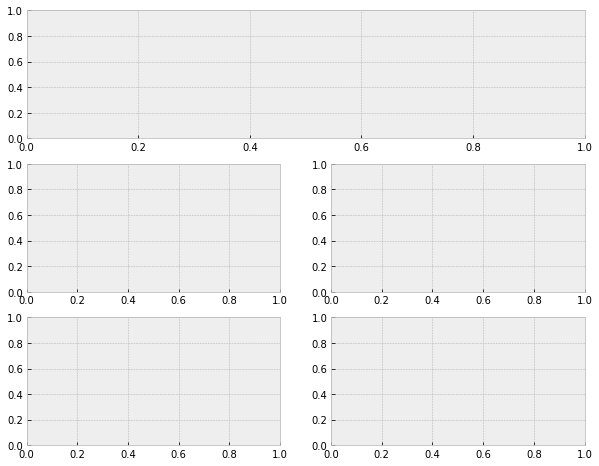

In [46]:
n = int(1000)

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
limit=12
_ = tsplot(arma22, lags=limit, title='ARMA(2,2) process')

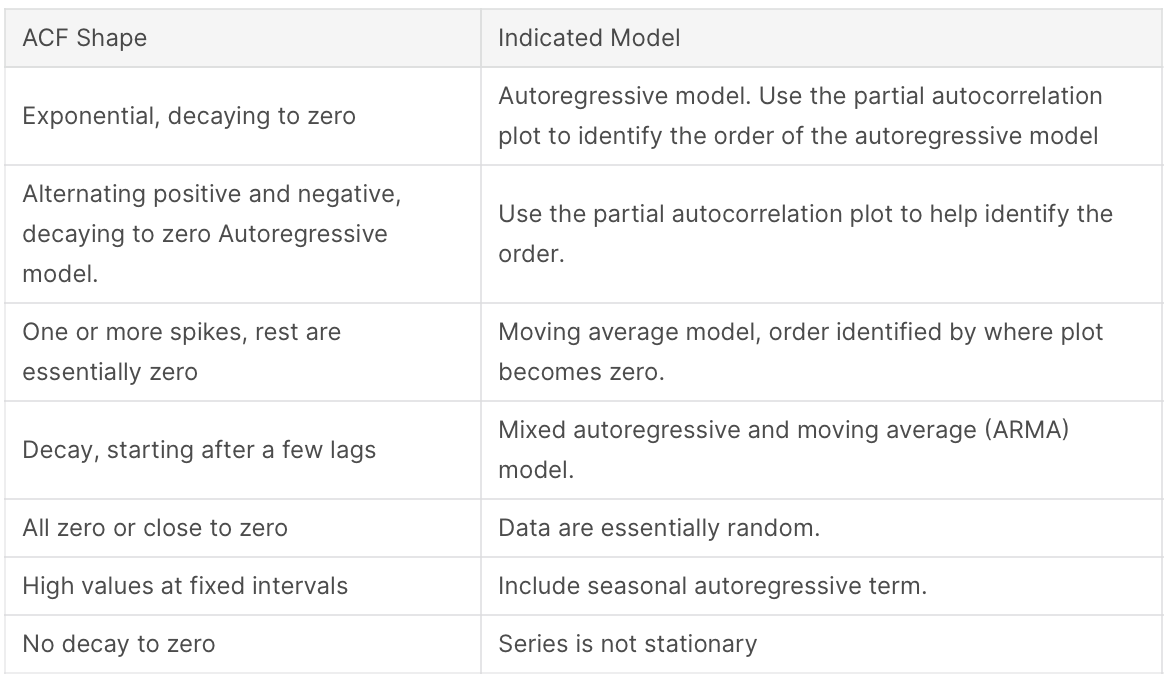

Let's use a systematic approach to find the right order of the AR and MA processes. 

In [47]:
best_aic = np.inf
best_order = None
best_mdl = None #model

for i in range(5):
    for j in range(5) :
        try :
            tmp_mdl = smt.ARMA(arma22, order=(i,j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic :
                best_aic = tmp_aic
                best_order = (i,j)
                best_mdl = tmp_mdl
        except:
            continue
print(best_mdl)
print('aic', best_aic)
print('order', best_order)

None
aic inf
order None


this has correctly identified the order of the above ARMA process. 

In [48]:
### Let's now check on the sales time series. 


best_aic = np.inf
best_order = None
best_mdl = None #model

for i in range(5):
    for j in range(5) :
        try :
            tmp_mdl = smt.ARMA(new_ts.values, order=(i,j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic :
                best_aic = tmp_aic
                best_order = (i,j)
                best_mdl = tmp_mdl
        except:
            continue
print(best_mdl)
print('aic', best_aic)
print('order', best_order)


None
aic inf
order None


In [49]:
### Using best_mdl.predict to predict the next values

In [50]:
plt.plot(best_mdl.predict())

AttributeError: 'NoneType' object has no attribute 'predict'

## End of Script ---> what are the next steps?

https://www.youtube.com/watch?v=ZoJ2OctrFLA&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3


### Taken from another notebook "Time Series Analysis and SARIMA Model"

https://www.kaggle.com/code/mesofianeyou/time-series-analysis-sarima-model

Time Series is an extrapolation method: we predict a future value that is outside of the range of known values. Whereas for other linear regrssion methods, we predict future values from a range of values.
<br> 
Example: predicting the number of ice cream cones sold. 

First interpolation approach: we predict it from the independent variable "temperature". The temperature is likely to happen again, and we kind of always have temperatures from the same range, no new temperature is likely to arise. 

Second extrapolation approach, that of time series, we predict the value based on previous values, those previous values will not happen again: today, yesterday is never gonna happen again. So we predict outside the range of what has already been seen. 

In [1]:
#pip install pmdarima

In [2]:
import numpy
import os
os.system("numpy --version")

32512

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from wordcloud import WordCloud
import datetime
import matplotlib as mpl
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import ARIMA
from pmdarima.arima import auto_arima

In [4]:
#pip install wordcloud

In [5]:
sales_train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')
item_categories=pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')

In [6]:
sales_train['date'] = sales_train['date'].apply(lambda x : datetime.datetime.strptime(x, '%d.%m.%Y'))

df_train = sales_train.copy()

In [7]:
sales_train = sales_train.set_index('date')

In [8]:
df_train['month'] = df_train['date'].dt.to_period('M')
df_train['month'] = df_train['month'].astype(str)
dff2=df_train.copy()
df_train['month'] = pd.to_datetime(df_train['month'])

In [9]:
dff_train = df_train.groupby(['month']).agg({'item_cnt_day' : 'sum'})
dff_train['month'] = dff_train.index
dff_train.drop(['month'], axis=1, inplace=True)
dff_train.rename(columns = {'item_cnt_day' : 'item_cnt_month'}, inplace=True)

In [10]:
#dff_train

In [11]:
### Check for stationarity
result = adfuller(dff_train)
def test_stationarity(ts):
    dftest = adfuller(ts, autolag='BIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Nb of lags used', 'Nb of observations used'])

    for key, value in dftest[4].items() :
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_stationarity(dff_train)

Test Statistic             -2.395704
p-value                     0.142953
Nb of lags used             0.000000
Nb of observations used    33.000000
Critical Value (1%)        -3.646135
Critical Value (5%)        -2.954127
Critical Value (10%)       -2.615968
dtype: float64


p-value > 0.05 so we reject the null hypothesis (a unit root is present in the time series sample), e.g., the time series is stationary. **Thus, the series is not stationary**

<AxesSubplot:xlabel='month'>

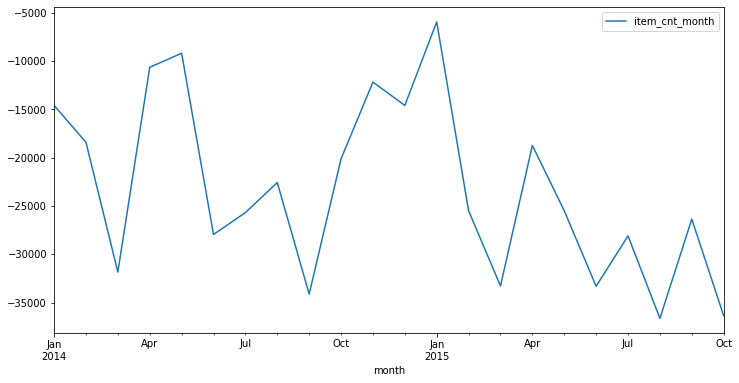

In [12]:
##Seasonal differencing
sd_dff_train = dff_train - dff_train.shift(12)
sd_dff_train = sd_dff_train.dropna()
sd_dff_train.plot(figsize=(12,6))


In [13]:
print(pd.__version__)

1.3.5


In [14]:
#!pip3 install numpy --upgrade

In [15]:
#!pip3 install --upgrade pip

In [16]:
#%matplotlib

In [17]:
#pip install statsmodels --upgrade

In [18]:
result = adfuller(sd_dff_train)
test_stationarity(sd_dff_train)

Test Statistic             -3.270101
p-value                     0.016269
Nb of lags used             0.000000
Nb of observations used    21.000000
Critical Value (1%)        -3.788386
Critical Value (5%)        -3.013098
Critical Value (10%)       -2.646397
dtype: float64


p-value < 0.05 so the series is stationary. ==> D=1. 

/Users/ruilapuskas/opt/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


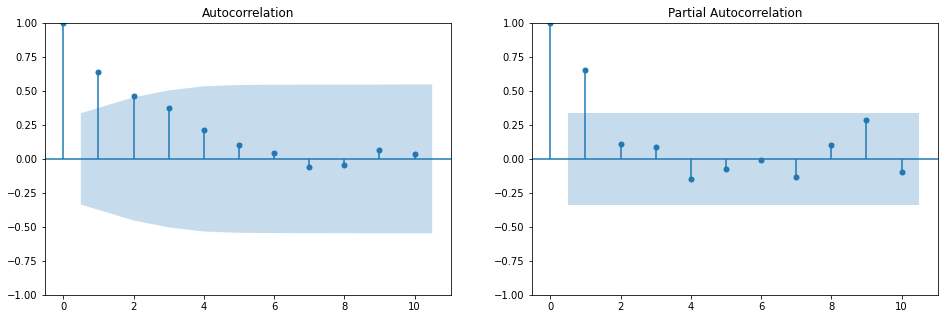

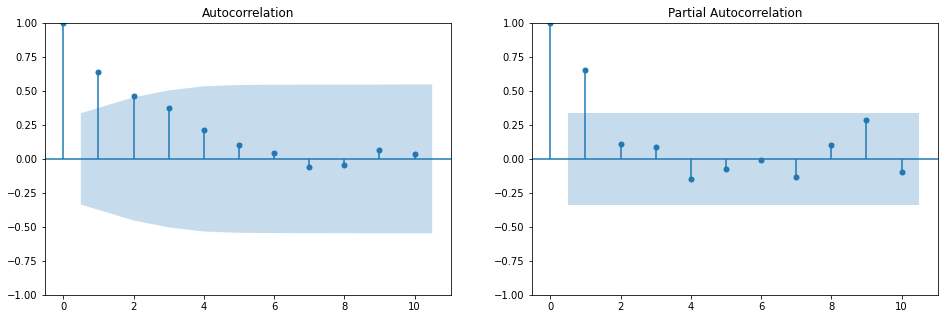

In [19]:
### In order to figure out the parameters (p, d, q, P, D, Q) of the SARIMA model, we plot the ACF and PACF curves. 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
plot_acf(dff_train, lags=10, ax=axes[0])
plot_pacf(dff_train, lags=10, ax=axes[1])


In [20]:
### let's now estimate the parameters of the auto arima model

model = auto_arima(dff_train, start_p=0, start_q=0, D=1, m=12, seasonal=True, test="adf", trace=True, alpha=0.05, information_criterion='aic', stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=448.765, Time=0.31 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=451.736, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=449.440, Time=0.04 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=438.095, Time=0.05 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=inf, Time=0.02 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=439.392, Time=0.09 sec
 ARIMA(0,2,1)(0,1,2)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=438.173, Time=0.05 sec
 ARIMA(0,2,1)(1,1,2)[12]             : AIC=440.703, Time=0.12 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=448.622, Time=0.02 sec
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(0,2,2)(0,1,1)[12]             : AIC=451.418, Time=0.05 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=449.122, Time=0.03 sec
 ARIMA(1,2,2)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(0,2,1)(0,1,1)[12] intercept   : AIC=439.27

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

The best model is SARIMA(0,2,1)(0,1,1)[12]

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   34
Model:             SARIMAX(0, 2, 1)x(0, 1, 1, 12)   Log Likelihood                -216.048
Date:                            Sat, 23 Jul 2022   AIC                            438.095
Time:                                    10:04:23   BIC                            441.082
Sample:                                         0   HQIC                           438.678
                                             - 34                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9856      0.298     -3.311      0.001      -1.569      -0.402
ma.S.L12      -0.0853      0.168     -0.509      0.611      -0.414       0.244
sigma2      2.062e+08   5.95e-10   3.46e+17      0.000    2.06e+08    2.06e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):                 0.89
Prob(Q):                              0.39   Prob(JB):                         0.64
Heteroskedasticity (H):               0.80   Skew:                             0.24
Prob(H) (two-sided):                  0.77   Kurtosis:                         2.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.33e+33. Standard errors may be unstable.
"""

* Ljung Box Test: are the residuals independent? Null hypothesis is that the residuals are independent: if p-value < 0.05 then we accept the hypothesis. 

* Jarque Bera Test: does the sample data follow a Normal distribution? If p-value < 0.05 then the sample data follows a normal distribution (null hypothesis accepted).

* Heteroskedasticity: are the variances of the errors the same? If p-value < 0.05 then we accept the null hypothesis that the variances are uniform. If not, we have heteroskedasticity. 

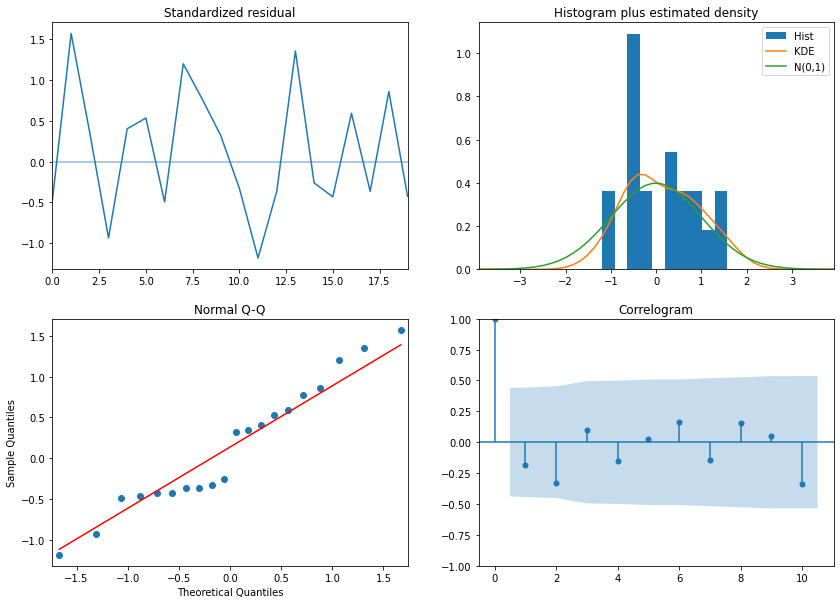

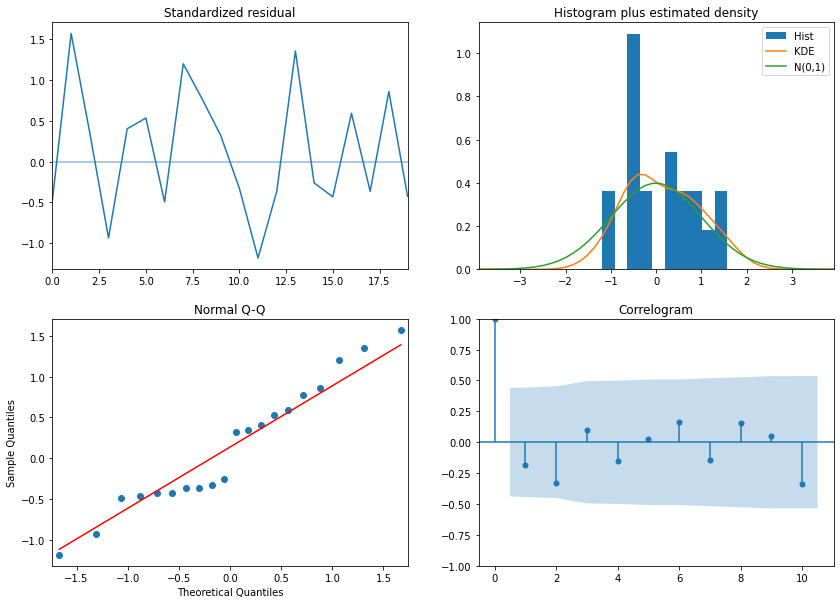

In [22]:
model.plot_diagnostics(figsize=(14,10))

In [23]:
### Forecasting

prediction, confint = model.predict(n_periods=6, return_conf_int=True)
period_index = pd.period_range(start=dff_train.index[-1], periods=6, freq='M')
forecast = pd.DataFrame({'Predicted item_cnt_month' : prediction.round(2)}, index=period_index)
forecast

,Predicted item_cnt_month
2015-10,77890.54
2015-11,125725.12
2015-12,65654.02
2016-01,37681.17
2016-02,33348.92
2016-03,24889.97


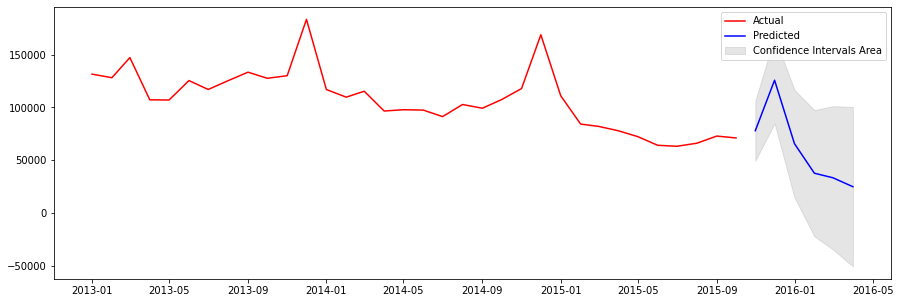

In [24]:
cf = pd.DataFrame(confint)

prediction_series = pd.Series(prediction, index=period_index)

plt.figure(figsize=(15,5))

plt.plot(dff_train, color='red', label='Actual')
plt.plot(prediction_series, color='blue', label='Predicted')
plt.fill_between(prediction_series.index, 
                 cf[0], cf[1], 
                 color='grey', alpha=0.2, 
                 label='Confidence Intervals Area')
plt.legend()
plt.show()

In [25]:
#%matplotlib